# Wearable Stress and Affect Detection (WESAD) Exploratory Data Analysis

## Part 3: Chest/Wrist Data Analysis + Comparison

### [UCI Link](https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29#)

'''
Philip Schmidt, Attila Reiss, Robert Duerichen, Claus Marberger and Kristof Van Laerhoven. 2018. 
Introducing WESAD, a multimodal dataset for Wearable Stress and Affect Detection. 
In 2018 International Conference on Multimodal Interaction (ICMI '18), October 16-20, 2018, Boulder, CO, USA. ACM, New York, NY, USA, 9 pages.
'''

This dataset is part of the UCI ML Data repository and contains high granularity data (700 Hz) of 15 test subjects from chest worn sensors (RespiBAN) in the form of:
  - Electrocardiography (ECG)
  - Electrodermal Activity (EDA)
  - Electromyography (EMG)
  - Body Temp (Temp)
  - Accelorometer (ACC)
  - Respiration % (Resp)
  
Contains data at lower granularity from wrist worn (non dominant) Empatica device in the form of:
  - Accelorometer (ACC)
  - BVP
  - Electrodermal Activity (EDA)
  - Body Temp (Temp)

Wearable data generation has exploded in recent years, and with it the analysis of it. Time series data can yield very interesting insights and can paint a picture of people's health that they would not be able to see themselves.

Let's explore this data and see what we find. **This notebook will compare chest + wrist data to see how well the data matches up. Chest worn sensors are specifically designed to capture minutae in physiological signals; wrist worn devices have it much harder trying to capture the same minutae.**

## Import Packages and Configure Settings

In [1]:
# Do this first so we can have plots in the cells
%matplotlib inline
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import pickle

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [3]:
# Choose ggplot
plt.style.use('ggplot')

# Before we start, let's fix the row/column displays so we can see all rows/columns
# Set ipython's max row display
pd.set_option('display.max_row', 100)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 100)

# Also for numpy, since we will be creating arrays off of the data
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

# Suppress scientific notation, show as decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Do this to have jupyter notebook displayed in FULL
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Preprocess & Clean Data

It's both exciting and exhausting to explore a data set without any context or guidance on how it should look/what issues may need to be accounted for. There's so many different possibilities that can be explored, but since no one has unlimited time on their hands one must always be diligent on how much time in spent in data cleaning + exploration.

Luckily for this dataset, the expected data format was already included with the data (and it is relatively easy to determine when exploring). I will still output some quick items for inspection like the df shape, columns and head. Let's go ahead and parse all the pickle files and create a subject dictionary of subject id-dataframe pairs.

In [4]:
# This is from the data_etl.py script
# Posting the format of the data below from the wesad_readme.pdf
"""
According to the README:
The double-tap signal pattern was used to manually synchronise the two devices' raw data. The result is provided in the files SX.pkl, one file per subject. This file is a dictionary, with the following keys:
- 'subject': SX, the subject ID
- 'signal': includes all the raw data, in two fields:
  - 'chest': RespiBAN data (all the modalities: ACC, ECG, EDA, EMG, RESP, TEMP)
  - 'wrist':EmpaticaE4data(all the modalities:ACC,BVP,EDA,TEMP)
- 'label': ID of the respective study protocol condition, sampled at 700 Hz. The following IDs
are provided: 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
"""

# Study protocal conditions (label) mapping
label_map = {
    0: 'not defined / transient',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
}


# Read in WESAD datasets by subject and unpickle
subject_dct = {}
path = '../../data/WESAD'
filenames = glob.glob(os.path.join(path,'*/*.pkl'))
for file in filenames:
    
    # Had to use 'latin1' as the encoding due to Python 2/3 pickle incompatibility
    # https://stackoverflow.com/questions/11305790/pickle-incompatibility-of-numpy-arrays-between-python-2-and-3
    unpickled_file = pickle.load(open(file,'rb'), encoding='latin1')
    # Grab relevant info
    subject_id = unpickled_file['subject']
    print('processing subject',subject_id)
    # Grab chest and wrist dataframes
    chest_dct = unpickled_file['signal']['chest']
    wrist_dct = unpickled_file['signal']['wrist']

    # Process the chest dictionary first as it is more straight forward
    # Since the 'ACC' column contains 3 dimensional tuples, it needs to be processed separately due to pandas expecting the same format for all columns
    # Going to create dictionaries without that column to turn into a dataframe, then add the 'ACC' values later
    tmp_chest_dct = dict((k, chest_dct[k].ravel()) for k in list(chest_dct.keys()) if k not in ['ACC'])
    tmp_chest_df = pd.DataFrame(tmp_chest_dct) # Contains everything except ACC
    tmp_acc_df = pd.DataFrame(chest_dct['ACC'],columns=['ACC_X','ACC_Y','ACC_Z']) # Manually declare keys, otherwise shows up as 0,1,2
    final_chest_df = pd.concat([tmp_chest_df,tmp_acc_df],axis=1)

    # Process wrist dictionary, which will take more care because the samplying frequencies were different 
    # Meaning the number of data points collected for each feature is different (higher frequency equals more data points)
    # Basically this one just needs to be processed manually
    wrist_acc_df = pd.DataFrame(wrist_dct['ACC'],columns=['ACC_X','ACC_Y','ACC_Z'])
    wrist_bvp_df = pd.DataFrame(wrist_dct['BVP'],columns=['BVP'])
    wrist_eda_df = pd.DataFrame(wrist_dct['EDA'],columns=['EDA'])
    wrist_temp_df = pd.DataFrame(wrist_dct['TEMP'],columns=['TEMP'])

    # Add labels as a separate object to be returned
    # While the time granularity is the same as the chest data, I'm not sure yet how to use it with the wrist data
    # So will just keep it separate and add as needed
    labels_df = pd.DataFrame(unpickled_file['label'],columns=['label'])
    labels_df['mapped_label'] = labels_df['label'].map(label_map)
    labels_df['SUBJECT_ID'] = subject_id
    
    # Add subject id to all dataframes
    for df in [final_chest_df, wrist_acc_df, wrist_bvp_df, wrist_eda_df, wrist_temp_df]:
        df['SUBJECT_ID'] = subject_id

    subject_dct[subject_id] = {
        'chest_df': final_chest_df,
        'wrist_dfs': {
            'wrist_acc_df': wrist_acc_df,
            'wrist_bvp_df': wrist_bvp_df,
            'wrist_eda_df': wrist_eda_df,
            'wrist_temp_df': wrist_temp_df,
        },
        'labels': labels_df,
    }

processing subject S5
processing subject S2
processing subject S3
processing subject S4
processing subject S17
processing subject S10
processing subject S11
processing subject S16
processing subject S8
processing subject S6
processing subject S7
processing subject S9
processing subject S13
processing subject S14
processing subject S15


# Jumping Straight to Data Comparison

We have already done basic exploratory analysis for both chest data (part 1) and wrist data (part 2), so it is assumed you (the reader) know what the data looks like. If you'd like more reference to data structure and types please refer to Part 1 or Part 2 of the Exploratory Data Analysis.

Let's jump straight to comparing the data. We'll start by taking a look at the range and frequency of values for each feature to see how well they match up via histograms.

**Note: Here I will be plotting the histograms with outliers removed since the full data was plotted in Part 1 & 2. Outliers will be defined as data points that extend 2.5 times the Inter Quartile Range (IQR) past the first and third quartile (i.e. all data points < (Q1 - (2.5 x IQR)) and all data points > Q3 + (2.5 x IQR)). Typically for outliers they fall into whatever extend 1.5 times the IQR past the first and third quartile, but doing this filters out alot of points. The idea here is to remove VERY incorrect data, so I made the  **

In [5]:
# Make a function that inputs a dataframe, calculates the quartiles and interquartile range of each feature, 
# then removes outliers according to the above criteria
def remove_outliers(df):
    df_description = df.describe()
    interquartile_ranges = pd.to_numeric(df_description.loc['75%']) -  pd.to_numeric(df_description.loc['25%'])
    lower_bound = (pd.to_numeric(df_description.loc['25%']) - (2.5 * interquartile_ranges)).to_frame().T
    upper_bound = (pd.to_numeric(df_description.loc['75%']) + (2.5 * interquartile_ranges)).to_frame().T
    # Iterate through columns one at a time + remove outliers
    cols_no_outliers = []
    #df.loc[(df['ACC_X'] > lb.to_frame().T['ACC_X'].ravel()[0]) & (df['ACC_X'] < ub.to_frame().T['ACC_X'].ravel()[0]),'ACC_X']
    for col in df.columns:
        col_lower_bound = lower_bound[col].ravel()[0]
        col_upper_bound = upper_bound[col].ravel()[0]
        col_no_outliers = df.loc[(df[col] > col_lower_bound) & (df[col] < col_upper_bound),col]
        cols_no_outliers.append(col_no_outliers)
    
    df_no_outliers = pd.concat(cols_no_outliers,axis=1)
    return df_no_outliers
    #return lower_bound,upper_bound
    #print('Lower bound:', lower_bound)
    #print('Upper bound:', upper_bound)
    #df_less_outliers = df.loc[(df < lower_bound and df > upper_bound),:]
    #print(df_less_outliers)

In [6]:
df_no_outliers = remove_outliers(subject_dct['S3']['chest_df'].drop(columns='SUBJECT_ID'))
display(df_no_outliers)

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z
0,nan,0.006,7.988,31.499,2.205,0.720,-0.138,nan
1,nan,-0.039,7.982,31.502,2.180,nan,nan,nan
2,nan,-0.049,7.983,31.521,2.167,nan,nan,nan
3,-0.536,-0.014,7.982,31.511,2.191,nan,nan,nan
4,-0.322,0.028,7.979,31.517,2.184,nan,nan,nan
...,...,...,...,...,...,...,...,...
4545095,-0.346,0.034,7.536,33.214,1.372,0.915,0.051,0.019
4545096,-0.305,-0.039,7.534,33.226,1.357,0.909,0.055,0.001
4545097,-0.248,nan,7.532,33.229,1.344,0.902,0.059,-0.008
4545098,-0.186,nan,7.531,33.215,1.341,0.907,0.076,0.003


In [7]:
display(df_no_outliers.isnull().sum())

ECG      234518
EMG      295794
EDA      167891
Temp          0
Resp      54953
ACC_X    160197
ACC_Y     45419
ACC_Z       135
dtype: int64

This is actually filtering out more data than I thought. For signal processing, it seems like this traditional method of extracting outliers may not be as appropriate.

**To Do: Search methods of time series outlier extraction specific to signal processing.**

## Histograms

In [8]:
subject_ids = list(subject_dct.keys())
display(subject_ids)

['S5',
 'S2',
 'S3',
 'S4',
 'S17',
 'S10',
 'S11',
 'S16',
 'S8',
 'S6',
 'S7',
 'S9',
 'S13',
 'S14',
 'S15']

In [9]:
# Concatenate all chest data
all_subjects_chest_data_df = pd.concat([subject_dct[subject_id]['chest_df'] for subject_id in subject_ids])
all_subjects_labels_df = pd.concat([subject_dct[subject_id]['labels']['label'] for subject_id in subject_ids])
all_subjects_chest_df = pd.concat([all_subjects_chest_data_df.reset_index(drop=True),all_subjects_labels_df.reset_index(drop=True)],axis=1)

In [10]:
# Concatenate all wrist data
all_subjects_wrist_acc_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_acc_df'] for subject_id in subject_ids],axis=0)
all_subjects_wrist_bvp_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_bvp_df'] for subject_id in subject_ids],axis=0)
all_subjects_wrist_eda_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_eda_df'] for subject_id in subject_ids],axis=0)
all_subjects_wrist_temp_df = pd.concat([subject_dct[subject_id]['wrist_dfs']['wrist_temp_df'] for subject_id in subject_ids],axis=0)

array([[<AxesSubplot:title={'center':'ECG'}>,
        <AxesSubplot:title={'center':'EMG'}>,
        <AxesSubplot:title={'center':'EDA'}>],
       [<AxesSubplot:title={'center':'Temp'}>,
        <AxesSubplot:title={'center':'Resp'}>,
        <AxesSubplot:title={'center':'ACC_X'}>],
       [<AxesSubplot:title={'center':'ACC_Y'}>,
        <AxesSubplot:title={'center':'ACC_Z'}>,
        <AxesSubplot:title={'center':'label'}>]], dtype=object)

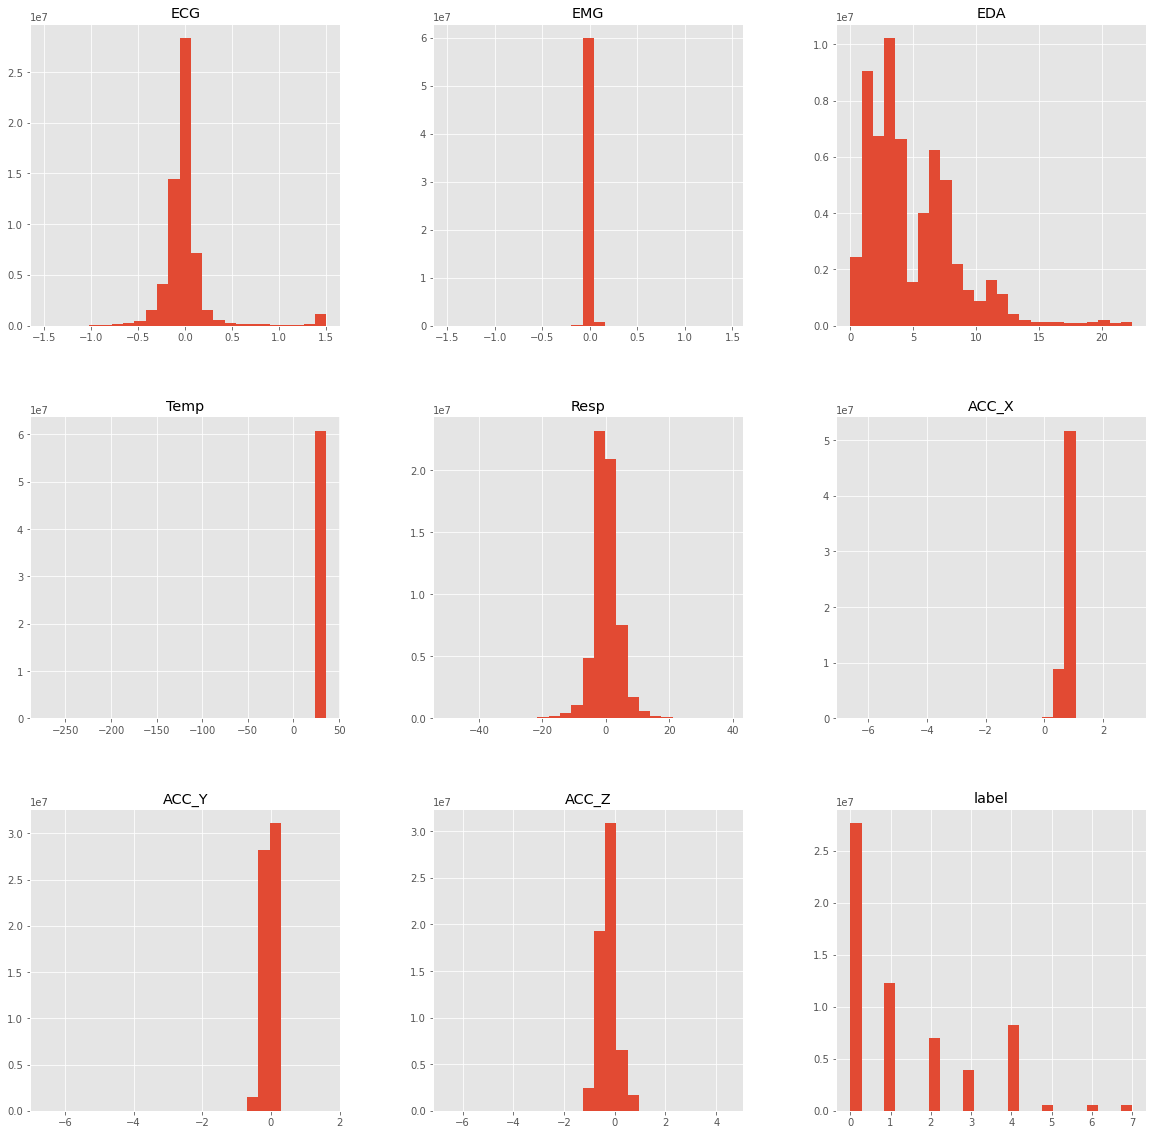

In [11]:
# Plot chest data histograms
all_subjects_chest_df.hist(figsize=(20,20),bins=25)

array([[<AxesSubplot:title={'center':'TEMP'}>]], dtype=object)

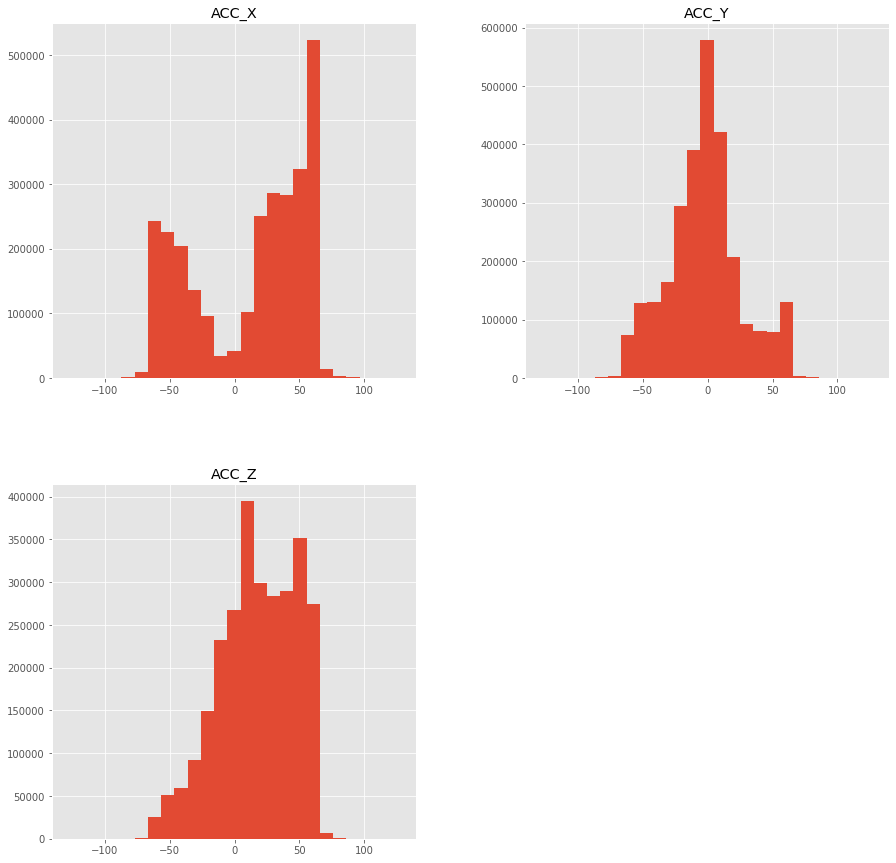

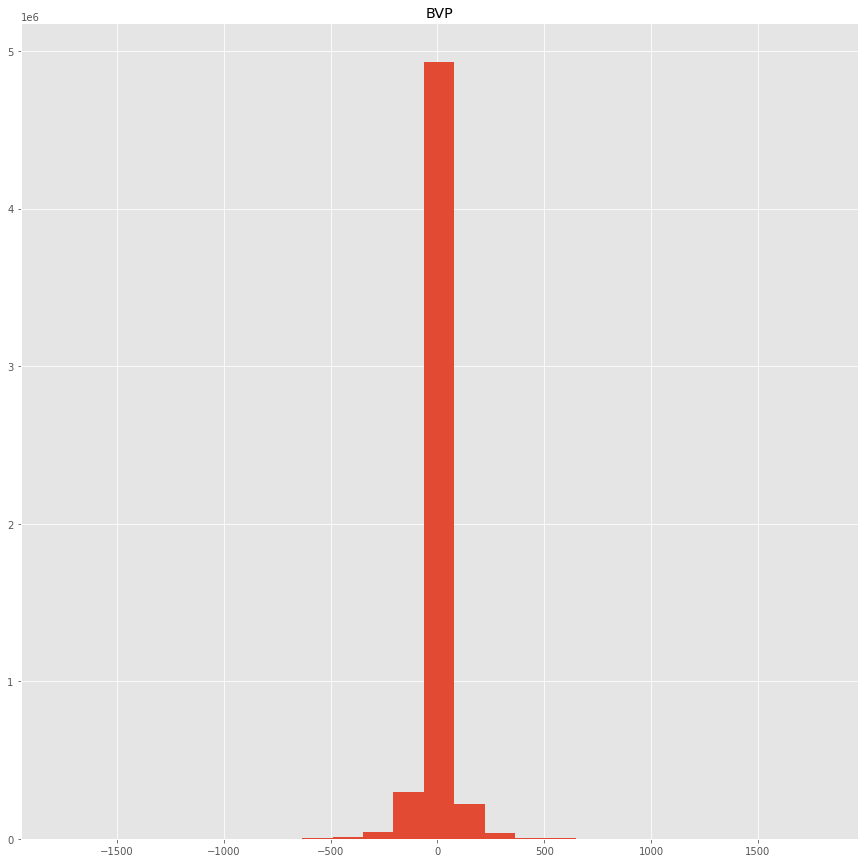

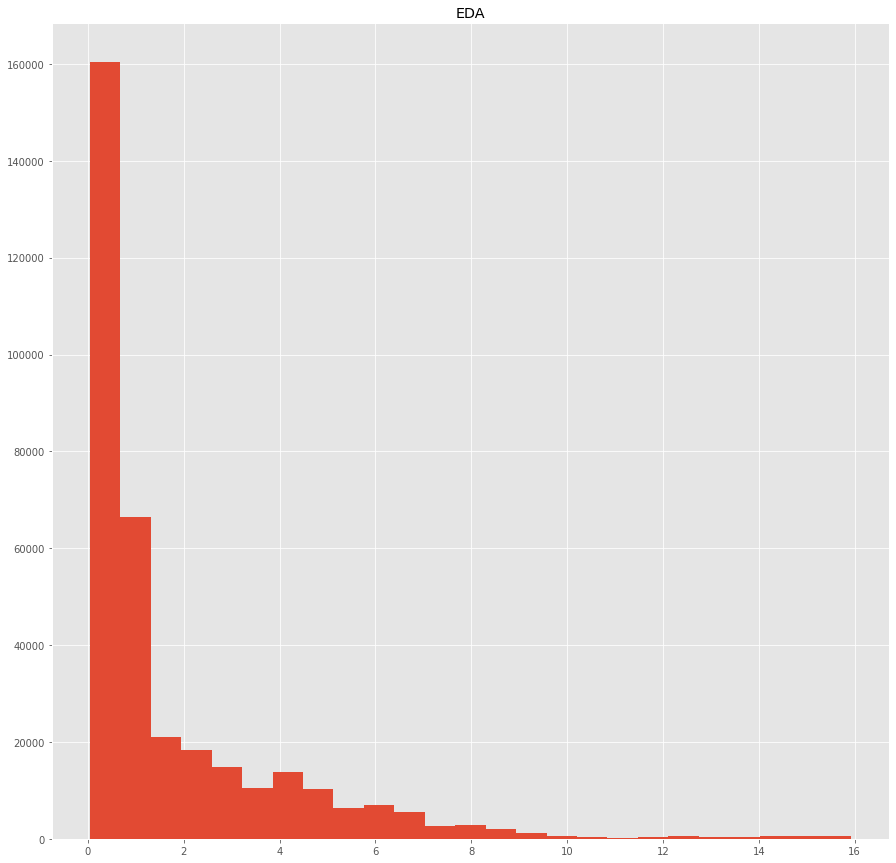

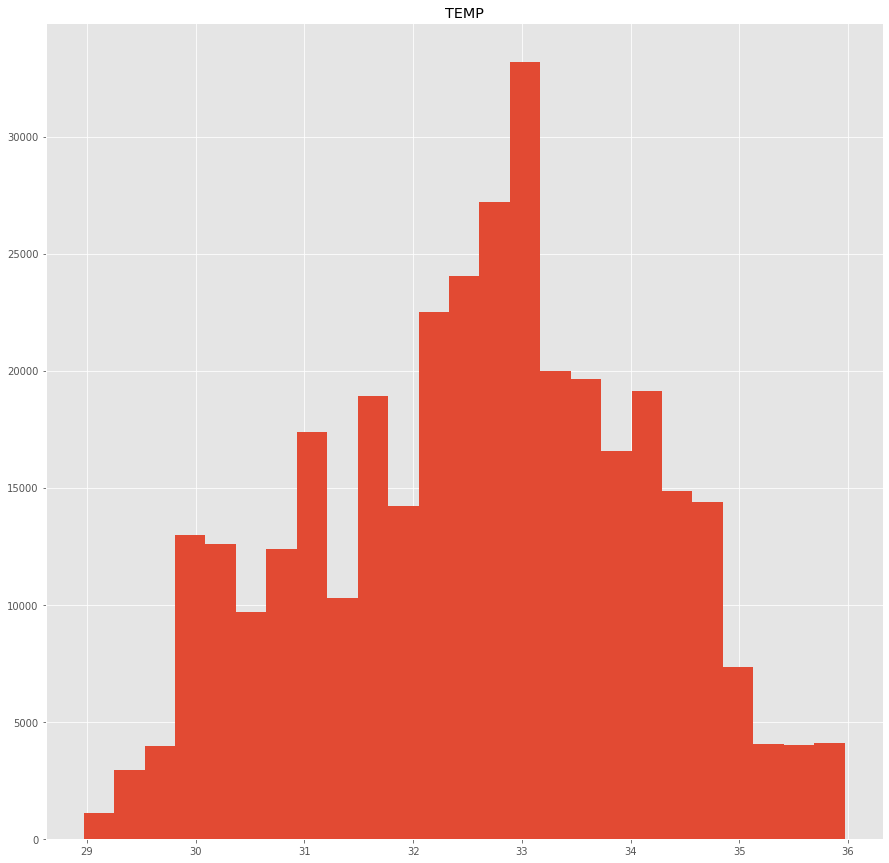

In [12]:
all_subjects_wrist_acc_df.hist(figsize=(15,15),bins=25)
all_subjects_wrist_bvp_df.hist(figsize=(15,15),bins=25)
all_subjects_wrist_eda_df.hist(figsize=(15,15),bins=25)
all_subjects_wrist_temp_df.hist(figsize=(15,15),bins=25)

# Scatter Plots

While the above descriptive statistics are helpful, it may be less clear how features with similar measures (mean, median, standard deviation, etc.) relate to each other (if at all). We should graph these features against each other and see how they relate to each other (negatively/positively, strong/weak, etc.). 

If we end up deciding to try and create a model later, this analysis will help us decide what variables to use and remove.

For this, we will import another visualization packages (seaborn) that has some nicer plotting features and functionalities.

## Corresponding Chest + Wrist Data

One big reason for doing experiments like these is to sync up the sensor data from the chest with the wrist. If someone REALLY wanted high quality data they could wear a chest sensor all day, but I have yet to meet a person who wouldn't rather just use a wrist worn device if they could.

Obviously comparing the chest and wrist data with different time granularities needs to be taken with a grain of salt but let's try it anyway. I will be doing the correlation on a subject by subject basis to see how the values corresponded.

For this, I will perform some different aggregations to get the chest data onto the same granularity as the wrist. We will certainly lose some information here, but let's see what we find:

## Chest ACC vs Wrist ACC

This one I expect the least differences to show up in since both ACC wrist and chest data are very dense. Let's see.

In [13]:
# Calculate mean and median of every N data points where N is the ratio of chest data points to wrist data points
# Using same idea as here: https://stackoverflow.com/questions/47239332/take-the-sum-of-every-n-rows-in-a-pandas-series
'''
for subject in subject_ids:
    ratio = subject_dct[subject]['chest_df']['ACC_X'].shape[0] / subject_dct[subject]['wrist_dfs']['wrist_acc_df']['ACC_X'].shape[0]
    print('Ratio for subject', subject, 'is', ratio)
'''
# Look at ACC correlations
corr_dct = {}
combined_dct = {}
N = 21.875 # Validated by code above
for subject in subject_ids:
    
    # Calculate mean/median for chest data
    df = subject_dct[subject]['chest_df']['ACC_X']
    mean = pd.DataFrame(df.groupby(df.index // N).mean()).rename(columns={'ACC_X': 'ACC_X_CHEST_MEAN'})
    median = pd.DataFrame(df.groupby(df.index // N).median()).rename(columns={'ACC_X': 'ACC_X_CHEST_MEDIAN'})
    combined = pd.concat([mean,median],axis=1)
    combined_dct[subject] = combined
    
    # Calculate correlation with wrist data
    wrist_df = subject_dct[subject]['wrist_dfs']['wrist_acc_df']['ACC_X']#.rename(columns={'ACC_X': 'ACC_X_WRIST'})
    all_data = pd.concat([wrist_df,combined],axis=1)
    corr_dct[subject] = all_data.corr()

In [14]:
display(list(corr_dct.items()))

[('S5',
                      ACC_X  ACC_X_CHEST_MEAN  ACC_X_CHEST_MEDIAN
  ACC_X               1.000            -0.338              -0.337
  ACC_X_CHEST_MEAN   -0.338             1.000               0.999
  ACC_X_CHEST_MEDIAN -0.337             0.999               1.000),
 ('S2',
                      ACC_X  ACC_X_CHEST_MEAN  ACC_X_CHEST_MEDIAN
  ACC_X               1.000            -0.342              -0.342
  ACC_X_CHEST_MEAN   -0.342             1.000               1.000
  ACC_X_CHEST_MEDIAN -0.342             1.000               1.000),
 ('S3',
                      ACC_X  ACC_X_CHEST_MEAN  ACC_X_CHEST_MEDIAN
  ACC_X               1.000            -0.091              -0.089
  ACC_X_CHEST_MEAN   -0.091             1.000               0.993
  ACC_X_CHEST_MEDIAN -0.089             0.993               1.000),
 ('S4',
                      ACC_X  ACC_X_CHEST_MEAN  ACC_X_CHEST_MEDIAN
  ACC_X               1.000             0.243               0.243
  ACC_X_CHEST_MEAN    0.243           

In [15]:
# Calculate mean and median of every N data points where N is the ratio of chest data points to wrist data points
# Using same idea as here: https://stackoverflow.com/questions/47239332/take-the-sum-of-every-n-rows-in-a-pandas-series
'''
for subject in subject_ids:
    ratio = subject_dct[subject]['chest_df']['ACC_Y'].shape[0] / subject_dct[subject]['wrist_dfs']['wrist_acc_df']['ACC_Y'].shape[0]
    print('Ratio for subject', subject, 'is', ratio)
'''
# Look at ACC correlations
corr_dct = {}
combined_dct = {}
N = 21.875 # Validated by code above
for subject in subject_ids:
    
    # Calculate mean/median for chest data
    df = subject_dct[subject]['chest_df']['ACC_Y']
    mean = pd.DataFrame(df.groupby(df.index // N).mean()).rename(columns={'ACC_Y': 'ACC_Y_CHEST_MEAN'})
    median = pd.DataFrame(df.groupby(df.index // N).median()).rename(columns={'ACC_Y': 'ACC_Y_CHEST_MEDIAN'})
    combined = pd.concat([mean,median],axis=1)
    combined_dct[subject] = combined
    
    # Calculate correlation with wrist data
    wrist_df = subject_dct[subject]['wrist_dfs']['wrist_acc_df']['ACC_Y']#.rename(columns={'ACC_Y': 'ACC_Y_WRIST'})
    all_data = pd.concat([wrist_df,combined],axis=1)
    corr_dct[subject] = all_data.corr()

In [16]:
display(list(corr_dct.items()))

[('S5',
                      ACC_Y  ACC_Y_CHEST_MEAN  ACC_Y_CHEST_MEDIAN
  ACC_Y               1.000             0.005               0.005
  ACC_Y_CHEST_MEAN    0.005             1.000               0.999
  ACC_Y_CHEST_MEDIAN  0.005             0.999               1.000),
 ('S2',
                      ACC_Y  ACC_Y_CHEST_MEAN  ACC_Y_CHEST_MEDIAN
  ACC_Y               1.000            -0.078              -0.078
  ACC_Y_CHEST_MEAN   -0.078             1.000               1.000
  ACC_Y_CHEST_MEDIAN -0.078             1.000               1.000),
 ('S3',
                      ACC_Y  ACC_Y_CHEST_MEAN  ACC_Y_CHEST_MEDIAN
  ACC_Y               1.000             0.254               0.249
  ACC_Y_CHEST_MEAN    0.254             1.000               0.994
  ACC_Y_CHEST_MEDIAN  0.249             0.994               1.000),
 ('S4',
                      ACC_Y  ACC_Y_CHEST_MEAN  ACC_Y_CHEST_MEDIAN
  ACC_Y               1.000             0.431               0.431
  ACC_Y_CHEST_MEAN    0.431           

In [17]:
# Calculate mean and median of every N data points where N is the ratio of chest data points to wrist data points
# Using same idea as here: https://stackoverflow.com/questions/47239332/take-the-sum-of-every-n-rows-in-a-pandas-series
'''
for subject in subject_ids:
    ratio = subject_dct[subject]['chest_df']['ACC_Z'].shape[0] / subject_dct[subject]['wrist_dfs']['wrist_acc_df']['ACC_Z'].shape[0]
    print('Ratio for subject', subject, 'is', ratio)
'''
# Look at ACC correlations
corr_dct = {}
combined_dct = {}
N = 21.875 # Validated by code above
for subject in subject_ids:
    
    # Calculate mean/median for chest data
    df = subject_dct[subject]['chest_df']['ACC_Z']
    mean = pd.DataFrame(df.groupby(df.index // N).mean()).rename(columns={'ACC_Z': 'ACC_Z_CHEST_MEAN'})
    median = pd.DataFrame(df.groupby(df.index // N).median()).rename(columns={'ACC_Z': 'ACC_Z_CHEST_MEDIAN'})
    combined = pd.concat([mean,median],axis=1)
    combined_dct[subject] = combined
    
    # Calculate correlation with wrist data
    wrist_df = subject_dct[subject]['wrist_dfs']['wrist_acc_df']['ACC_Z']#.rename(columns={'ACC_Z': 'ACC_Y_WRIST'})
    all_data = pd.concat([wrist_df,combined],axis=1)
    corr_dct[subject] = all_data.corr()

In [18]:
display(list(corr_dct.items()))

[('S5',
                      ACC_Z  ACC_Z_CHEST_MEAN  ACC_Z_CHEST_MEDIAN
  ACC_Z               1.000             0.062               0.062
  ACC_Z_CHEST_MEAN    0.062             1.000               1.000
  ACC_Z_CHEST_MEDIAN  0.062             1.000               1.000),
 ('S2',
                      ACC_Z  ACC_Z_CHEST_MEAN  ACC_Z_CHEST_MEDIAN
  ACC_Z               1.000             0.260               0.260
  ACC_Z_CHEST_MEAN    0.260             1.000               1.000
  ACC_Z_CHEST_MEDIAN  0.260             1.000               1.000),
 ('S3',
                      ACC_Z  ACC_Z_CHEST_MEAN  ACC_Z_CHEST_MEDIAN
  ACC_Z               1.000             0.183               0.183
  ACC_Z_CHEST_MEAN    0.183             1.000               1.000
  ACC_Z_CHEST_MEDIAN  0.183             1.000               1.000),
 ('S4',
                      ACC_Z  ACC_Z_CHEST_MEAN  ACC_Z_CHEST_MEDIAN
  ACC_Z               1.000             0.313               0.313
  ACC_Z_CHEST_MEAN    0.313           

### Chest EDA vs Wrist EDA

In [19]:
# Calculate mean and median of every N data points where N is the ratio of chest data points to wrist data points
# Using same idea as here: https://stackoverflow.com/questions/47239332/take-the-sum-of-every-n-rows-in-a-pandas-series
'''
for subject in subject_ids:
    ratio = subject_dct[subject]['chest_df']['EDA'].shape[0] / subject_dct[subject]['wrist_dfs']['wrist_eda_df'].shape[0]
    print('Ratio for subject', subject, 'is', ratio)
'''
# Look at EDA correlations
corr_dct = {}
combined_dct = {}
N = 175 # Validated by code above
for subject in subject_ids:
    
    # Calculate mean/median for chest data
    df = subject_dct[subject]['chest_df']['EDA']
    mean = pd.DataFrame(df.groupby(df.index // N).mean()).rename(columns={'EDA': 'EDA_CHEST_MEAN'})
    median = pd.DataFrame(df.groupby(df.index // N).median()).rename(columns={'EDA': 'EDA_CHEST_MEDIAN'})
    combined = pd.concat([mean,median],axis=1)
    combined_dct[subject] = combined
    
    # Calculate correlation with wrist data
    wrist_df = subject_dct[subject]['wrist_dfs']['wrist_eda_df'].rename(columns={'EDA': 'EDA_WRIST'})
    all_data = pd.concat([wrist_df,combined],axis=1)
    corr_dct[subject] = all_data.corr()

In [20]:
display(list(corr_dct.items()))

[('S5',
                    EDA_WRIST  EDA_CHEST_MEAN  EDA_CHEST_MEDIAN
  EDA_WRIST             1.000           0.675             0.675
  EDA_CHEST_MEAN        0.675           1.000             1.000
  EDA_CHEST_MEDIAN      0.675           1.000             1.000),
 ('S2',
                    EDA_WRIST  EDA_CHEST_MEAN  EDA_CHEST_MEDIAN
  EDA_WRIST             1.000           0.779             0.779
  EDA_CHEST_MEAN        0.779           1.000             1.000
  EDA_CHEST_MEDIAN      0.779           1.000             1.000),
 ('S3',
                    EDA_WRIST  EDA_CHEST_MEAN  EDA_CHEST_MEDIAN
  EDA_WRIST             1.000           0.381             0.381
  EDA_CHEST_MEAN        0.381           1.000             1.000
  EDA_CHEST_MEDIAN      0.381           1.000             1.000),
 ('S4',
                    EDA_WRIST  EDA_CHEST_MEAN  EDA_CHEST_MEDIAN
  EDA_WRIST             1.000           0.790             0.790
  EDA_CHEST_MEAN        0.790           1.000             1.000
  

### Chest Temp vs Wrist Temp

In [21]:
'''
for subject in subject_ids:
    ratio = subject_dct[subject]['chest_df']['Temp'].shape[0] / subject_dct[subject]['wrist_dfs']['wrist_eda_df'].shape[0]
    print('Ratio for subject', subject, 'is', ratio)
'''
# Body temperature correlations
corr_dct = {}
combined_dct = {}
N = 175 # Validated by code above
for subject in subject_ids:
    
    # Calculate mean/median for chest data
    df = subject_dct[subject]['chest_df']['Temp']
    mean = pd.DataFrame(df.groupby(df.index // N).mean()).rename(columns={'Temp': 'Temp_CHEST_MEAN'})
    median = pd.DataFrame(df.groupby(df.index // N).median()).rename(columns={'Temp': 'Temp_CHEST_MEDIAN'})
    combined = pd.concat([mean,median],axis=1)
    combined_dct[subject] = combined
    
    # Calculate correlation with wrist data
    wrist_df = subject_dct[subject]['wrist_dfs']['wrist_temp_df'].rename(columns={'Temp': 'Temp_WRIST'})
    all_data = pd.concat([wrist_df,combined],axis=1)
    corr_dct[subject] = all_data.corr()

In [22]:
display(list(corr_dct.items()))

[('S5',
                     TEMP  Temp_CHEST_MEAN  Temp_CHEST_MEDIAN
  TEMP              1.000            0.207              0.207
  Temp_CHEST_MEAN   0.207            1.000              1.000
  Temp_CHEST_MEDIAN 0.207            1.000              1.000),
 ('S2',
                      TEMP  Temp_CHEST_MEAN  Temp_CHEST_MEDIAN
  TEMP               1.000           -0.587             -0.587
  Temp_CHEST_MEAN   -0.587            1.000              1.000
  Temp_CHEST_MEDIAN -0.587            1.000              1.000),
 ('S3',
                      TEMP  Temp_CHEST_MEAN  Temp_CHEST_MEDIAN
  TEMP               1.000           -0.485             -0.734
  Temp_CHEST_MEAN   -0.485            1.000              0.651
  Temp_CHEST_MEDIAN -0.734            0.651              1.000),
 ('S4',
                      TEMP  Temp_CHEST_MEAN  Temp_CHEST_MEDIAN
  TEMP               1.000           -0.778             -0.778
  Temp_CHEST_MEAN   -0.778            1.000              1.000
  Temp_CHEST_MEDIAN -

# Conclusions

We see a range of correlations between the wrist data and the aggregated chest data for each subject; there could be many reasons for these differences:
  - How tightly the wrist and chest devices were worn + if they became loose at some point during the experiment
  - The sensors in the wrist and/or chest are inconsistent at picking up the data
  - Some of the sensors had small/temporary malfunctions
      - It is not uncommon for wrist worn devices to randomly stop picking up data

Something unxpected (although not surprising) is that for most of the subjects the median and mean chest data had the exact same correlation with the wrist data; this would seem to eliminate the idea that the chest sensor was inconsistent in picking up data since the data is probably more uniformly distributed than the wrist data.

Some interesting exceptions where the mean and median correlations were different:
  - Subject 3 (by a significant amount except for ACC_Z)
  - Subject 17 (by a very small amount in EDA and Temperature, but still different)
  
The accelerometer data had a wide range of values, so some of the lower correlations here did not surprise me. Also potentially clouding this is the fact that the wrist sensor will almost certainly be moving alot more than the chest sensor during the experiment. This makes me believe we shouldn't make any strong conclusions from these results.

The EDA correlations were mostly strongly positive (with some exceptions), which is a good sign for whatever sensor was in the wrist worn device.

The temperature correlations were on the high side but in the negative direction, which is very much a surprise. I would speculate that this is due to the lag in the wrist worn sensor picking up data: the chest sensor would pick up temperature changes first and start changing while the wrist worn sensor lags behind and then changes (while the temperature from the chest sensor could be going back to the original starting place). But this could also be due to the fact that the wrist worn device is not being covered while the chest worn device is under a shirt of some sort.

Would be an interesting experiment to see if introducing a lag to the chest sensor data would make these correlation values higher.

## Suitability of Data for Features as Clustering

Later on, I will be performing an exercise in clustering by extracting time series features (trend, seasonality, non-linearity, etc.) and then clustering on these. The extracted features may end up looking wildly different than the actual data, but I will make the following hypothesis:

- The mostly low correlations will allow for all of the features to be used for clustering
- The higher correlations for wrist/chest EDA + wrist/chest temperature will mean that only one of each (I will pick chest) should be used for clustering

Will draw conclusions in a separate notebook/script and refer back to my hypothesis above.